# What is causing incorrect PAC measures?

Calculating correlations between the phase of a lower frequency and the amplitude of an higher frequency will not only measure true interactions between oscillators, but also gives spurious PAC caused by using Fourier or wavelet based transformations on non-sinusoidal characteristics of signals. In this notebook I will show a short example on how this spurious PAC arises, based on simulated data from Kramer et al., 2008.

### Import packages and self-defined modules

In [1]:
import os
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')


# imports
from scipy import signal
import numpy as np
from scipy.signal import hilbert
from neurodsp import spectral
from fooof import FOOOF
from neurodsp.plts.spectral import plot_power_spectra
import matplotlib.pyplot as plt
import scipy as sp


os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab\Code\distinguish_pac')
import module_pac_functions as pacf

### Create Simulated Signal

In [2]:
# create 2 second signal with 6 Hz signal
plt_time = [0, 1000]
fs = 1000

f =12.0; 
dt = 0.001;
sig = [];

    
fi = 50.0;
fii = 10.0;

for hello in range(0,400): 
    
    # create two parts of the theta wave and concat them    
    x1 = -np.cos(np.pi* np.linspace(0,1,int(1/(dt*f))+1))
    x2 =  np.cos(np.pi* np.linspace(0,1,int(1/(dt*f))+1))
    
    theta = np.concatenate((x1, x2), axis=None);   
    
    #Define the duration of the sharp edge
    r = np.ceil(np.random.rand()*5);  
    
    #Create the sharp edge
    x3i = np.linspace(0,1,int(r+1));                   
   
    #Define the taper of the sharp edge
    x3ii = (np.cos(np.pi * np.linspace(0,1,int(1/(dt*fii))+1)) + 1) / 2 
    
    #Create the tapered sharp edge
    x3 = np.concatenate((x3i, x3ii), axis=None);       

    # Insert the sharp edge into the sinusoid
    pos = np.ceil(np.random.rand()*10)+15;             
    seed1 = theta[:]
    seed1[int(pos)-1:int(pos+len(x3))-1] = seed1[int(pos)-1:int(pos+len(x3))-1]+x3;

    sig.extend(seed1)
    
# add noise to the signal
sig = sig + 0.1*np.random.normal(-2, 2, np.shape(sig));


(-49.95, 1048.95, -1.839473675686873, 1.8888161187407573)

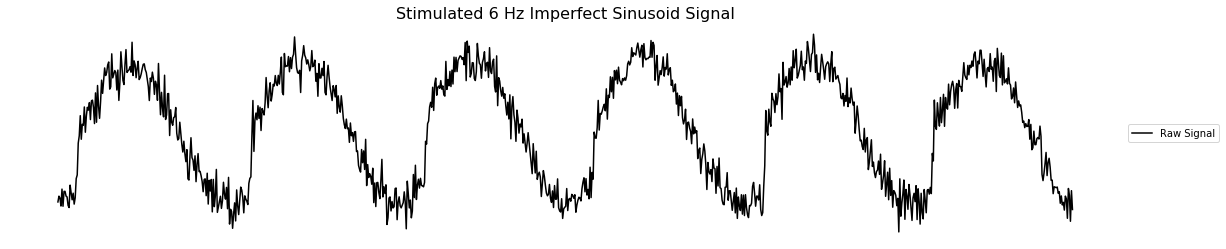

In [3]:
plt.figure(figsize = (20,4));
plt.plot((sig[plt_time[0]:plt_time[1]]),label= 'Raw Signal',color='black')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Stimulated 6 Hz Imperfect Sinusoid Signal', size=16)
plt.axis('off')

### Calculate and Plot the Theta Phase Band 

In [4]:
# set range between 4 and 8 Hz, expecting 6 Hz to be central frequency   
phase_providing_band = [4,8]

# use butter bandpass filter to extract this frequency range
phase_data = pacf.butter_bandpass_filter(sig, phase_providing_band[0], phase_providing_band[1], round(float(fs)));\

# hilbert transfer data
phase_data_hilbert = hilbert(phase_data);

# calculate the phase of the signal by using angle 
phase_data_angle = np.angle(phase_data_hilbert);

C:\Users\jaapv\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-49.95, 1048.95, -1.839473675686873, 1.8888161187407573)

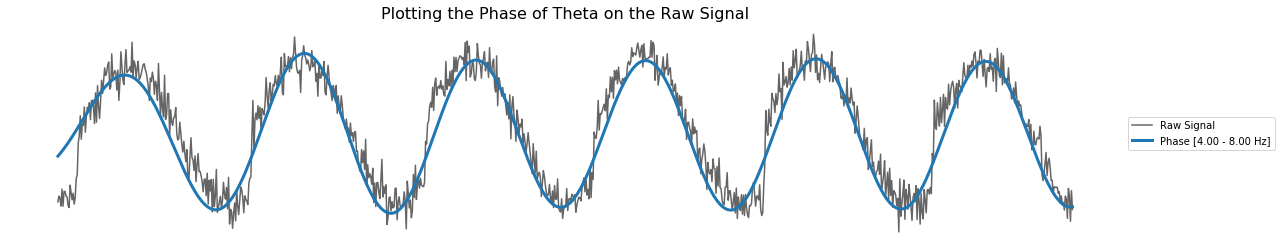

In [5]:
plt.figure(figsize = (20,4));
plt.plot((sig[plt_time[0]:plt_time[1]]),label= 'Raw Signal', color='black', alpha=.6)
plt.plot((phase_data_hilbert[plt_time[0]:plt_time[1]]),
         label= 'Phase [{0:.2f} - {1:.2f} Hz]'.format(phase_providing_band[0], phase_providing_band[1]),
         linewidth=3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Plotting the Phase of Theta on the Raw Signal', size=16)
plt.axis('off')

### Calculate and Plot the High Gamma Amplitude Band 

In [8]:
# set range of the band 
amplitude_providing_band = [40,80]

# use butter bandpass filter to extract this frequency range
amp_data = pacf.butter_bandpass_filter(sig, amplitude_providing_band[0], amplitude_providing_band[1], round(float(fs)));

# hilbert transform data
amp_data_hilbert = hilbert(amp_data);

# calculate absolute values
amp_data_abs = abs(amp_data_hilbert);  

(-49.95, 1048.95, -1.839473675686873, 1.8888161187407573)

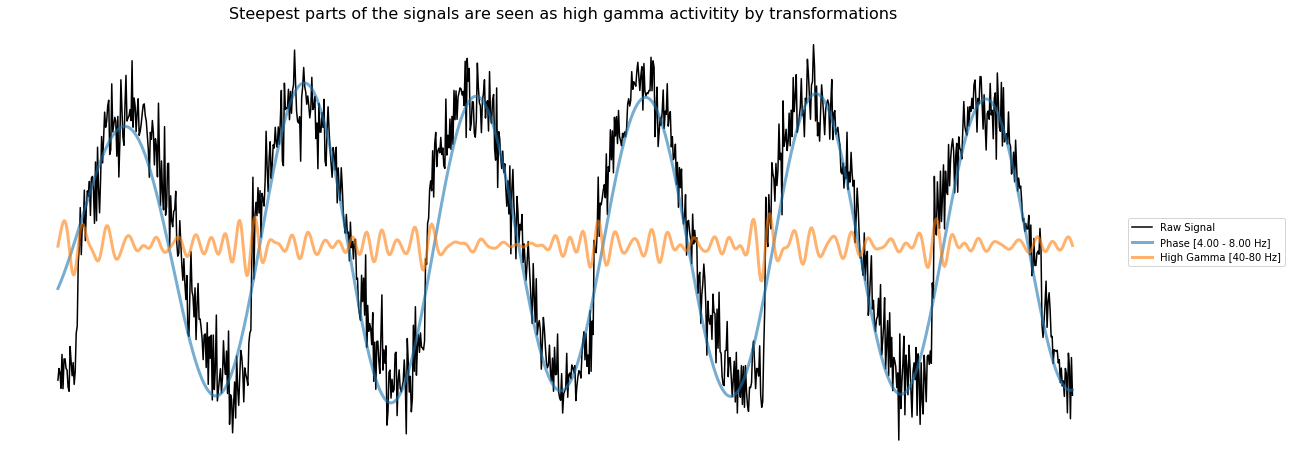

In [13]:
plt.figure(figsize = (20,8));
plt.plot((sig[plt_time[0]:plt_time[1]]),label= 'Raw Signal', color='black', alpha=1)
plt.plot((phase_data_hilbert[plt_time[0]:plt_time[1]]),
         label= 'Phase [{0:.2f} - {1:.2f} Hz]'.format(phase_providing_band[0], phase_providing_band[1]),
         linewidth=3, alpha=.6)
plt.plot((amp_data_hilbert[plt_time[0]:plt_time[1]]),label= 'High Gamma [40-80 Hz]',
         linewidth=3, alpha=.6)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Steepest parts of the signals are seen as high gamma activitity by transformations ', size=16)
plt.axis('off')

### Calculate the PAC

In [9]:
# Function for circle correlation
def circCorr(ang,line):
    n = len(ang)
    rxs = sp.stats.pearsonr(line,np.sin(ang))
    rxs = rxs[0]
    rxc = sp.stats.pearsonr(line,np.cos(ang))
    rxc = rxc[0]
    rcs = sp.stats.pearsonr(np.sin(ang),np.cos(ang))
    rcs = rcs[0]
    rho = np.sqrt((rxc**2 + rxs**2 - 2*rxc*rxs*rcs)/(1-rcs**2)) #r
    r_2 = rho**2 #r squared
    pval = 1- sp.stats.chi2.cdf(n*(rho**2),1)
    standard_error = np.sqrt((1-r_2)/(n-2))

    return rho, pval, r_2,standard_error

The Rho-value of PAC is:      0.27078693481719607
The p-value of PAC is:        0.0


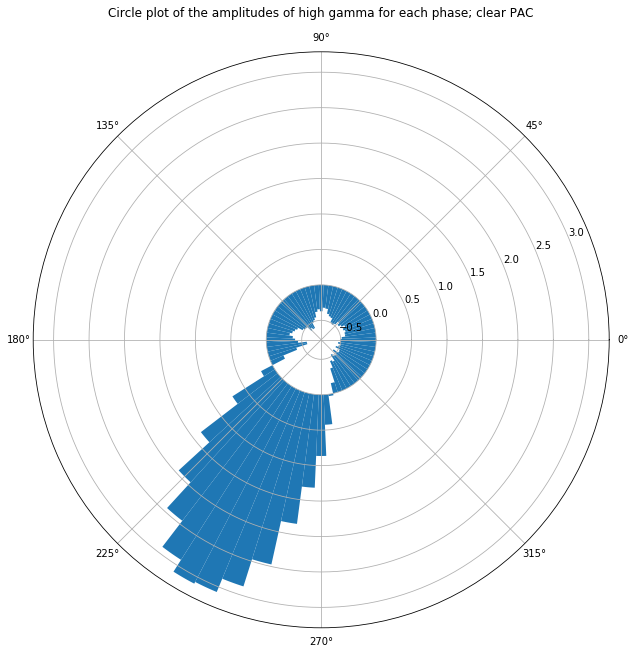

In [10]:
#this takes a while to run. 
#If you make bin_size larger (36) it will run much quicker but the effect won't be as clear.
bin_size = 5; 
bins = range(-180,180+bin_size,bin_size); 
bins = np.dot(bins, 0.0174532925);

amps = [];

#filling phase bins with amplitudes
for x in range(len(bins)-1):
    # find the lower bound of the bin
    amps_above_lo_bound = np.where(phase_data_angle >= bins[x])[0];
    # find the higher bound of the bin
    amps_below_hi_bound = np.where(phase_data_angle < bins[x+1])[0];
    amps_below_hi_bound = set(amps_below_hi_bound);
    # select all samples that are within the range
    amp_inds_in_this_bin = [amp_val for amp_val in amps_above_lo_bound if amp_val in amps_below_hi_bound]
    # find corresponding amplitudes for these samples
    amps_in_this_bin = amp_data_abs[amp_inds_in_this_bin];
    # calculate mean
    amps.append(np.mean(amps_in_this_bin));

bins = bins[:len(bins)-1];

#normalizing to make the effect more clear
amps = (amps-np.mean(amps))/np.std(amps);

#plotting figure;
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 1, 1], polar=True)
ax.bar(bins, amps, width=bins[1]-bins[0], bottom=0.0)
plt.title('Circle plot of the amplitudes of high gamma for each phase; clear PAC');

#calculate circle correlation
rho, pval, r_2, standard_error = circCorr(phase_data_angle, amp_data_abs)

print('The Rho-value of PAC is:     ', rho)
print('The p-value of PAC is:       ', pval)

